<a href="https://colab.research.google.com/github/Thadchet/Pattern-Recognition/blob/master/ProjectPattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D ,GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
from keras import backend as K
from scipy.optimize import differential_evolution
from numpy.linalg import norm

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['.config', 'sample_data']


In [0]:
import sys
print(sys.executable)

/usr/bin/python3


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [0]:
# Define path to the data directory
data_dir = Path('./drive/My Drive/Pattern Recognition/Dataset/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [0]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,drive/My Drive/Pattern Recognition/Dataset/che...,1
1,drive/My Drive/Pattern Recognition/Dataset/che...,1
2,drive/My Drive/Pattern Recognition/Dataset/che...,1
3,drive/My Drive/Pattern Recognition/Dataset/che...,1
4,drive/My Drive/Pattern Recognition/Dataset/che...,1


1    3875
0    1357
Name: label, dtype: int64


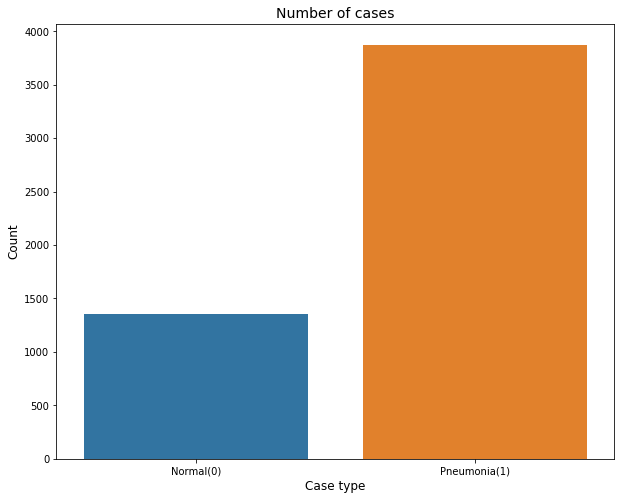

In [0]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [0]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 1)


In [0]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 1)


In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,1), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
              
           # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = [label]
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = [label]
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = [label]
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

# **Train Model**

In [0]:
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(100, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [0]:
model =  build_model()
# # model.load_weights('weight1.h5')
# model.summary()











87916544/87910968 [==============================] - 2s 0us/step


In [0]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

NameError: ignored

In [0]:
batch_size = 32
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 163 and 16


In [0]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

NameError: ignored

In [0]:
# summarize history for accuracy
plt.figure(figsize=(12,6),)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy',color = 'white')
plt.ylabel('accuracy',color = 'white')
plt.xlabel('epoch',color = 'white')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',color = 'white')
plt.ylabel('loss',color = 'white')
plt.xlabel('epoch',color = 'white')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
624/624 [==============================] - 12s 19ms/step
Loss on test set:  0.7929292680629283
Accuracy on test set:  0.8766025641025641


# **Model Averaging Ensemble**


In [0]:
%cd drive/My Drive/Pattern Recognition/models

/content/drive/My Drive/Pattern Recognition/models


In [0]:
def model_compile(model):
  opt = Adam(lr=0.0001, decay=1e-5)
  es = EarlyStopping(patience=5)
  chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
  model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
#load model to member list
member =  []
for i in range(9):
  model = build_model()
  model.load_weights('weight' + str(i+1)+'.h5')
  print('weight' + str(i+1)+'.h5' + ' : appended')
  member.append(model)











87916544/87910968 [==============================] - 3s 0us/step
weight1.h5 : appended
weight2.h5 : appended
weight3.h5 : appended
weight4.h5 : appended
weight5.h5 : appended
weight6.h5 : appended
weight7.h5 : appended
weight8.h5 : appended
weight9.h5 : appended


ROC represent all model

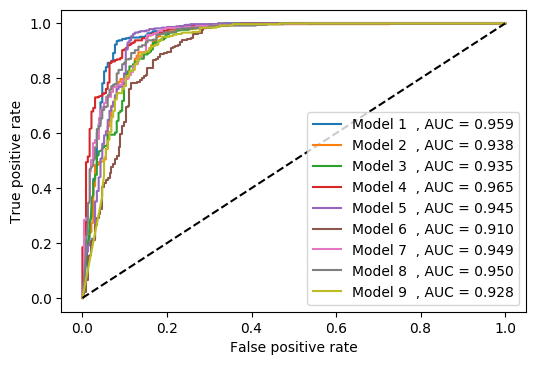

In [0]:
all_fpr = []
all_tpr = []
all_roc_auc =[]
plt.figure(dpi=100)
for i in range(len(member)):
  fpr , tpr , _=  roc_curve(test_labels,member[i].predict(test_data, batch_size=16))
  roc_auc = auc(fpr,tpr)
  all_fpr.append(fpr)
  all_tpr.append(tpr)
  all_roc_auc.append(roc_auc)
  plt.plot(all_fpr[i],all_tpr[i],label='Model %d  , AUC = %0.3f' % (i+1,all_roc_auc[i]))
plt.legend(loc= 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()


In [0]:
def ensemble_predictions(members, testX):
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	summed = np.sum(yhats,axis=0)/len(members)
	summed[summed > 0.5] = 1
	summed[summed <= 0.5] = 0
	result = summed.reshape(-1,)
	return result

def ensemble_predictions_for_roc_model_average(members, testX):
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	summed = np.sum(yhats,axis=0)/len(members)
	result = summed.reshape(-1,)
	return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

Reshape test_labels

In [0]:
test_label = test_labels.reshape(-1,)

In [0]:
for i in range(1, len(member)+1):
	model_compile(member[i-1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
for i in range(len(member)):
  _, test_score = member[i].evaluate(test_data, test_labels, batch_size=16,verbose = 0)
  print("Model {} Accuracy on test set: {:.3f}".format(i+1,test_score))

Model 1 Accuracy on test set: 0.877
Model 2 Accuracy on test set: 0.848
Model 3 Accuracy on test set: 0.800
Model 4 Accuracy on test set: 0.744
Model 5 Accuracy on test set: 0.854
Model 6 Accuracy on test set: 0.838
Model 7 Accuracy on test set: 0.870
Model 8 Accuracy on test set: 0.819
Model 9 Accuracy on test set: 0.837


In [0]:
ensemble_scores = []
single_scores = []

for i in range(1, len(member)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(member, i, test_data, test_label)
	# evaluate the i'th model standalone
	
	_, single_score = member[i-1].evaluate(test_data, test_labels, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

> 1: single=0.877, ensemble=0.877
> 2: single=0.848, ensemble=0.864
> 3: single=0.800, ensemble=0.838
> 4: single=0.744, ensemble=0.816
> 5: single=0.854, ensemble=0.825
> 6: single=0.838, ensemble=0.830
> 7: single=0.870, ensemble=0.841
> 8: single=0.819, ensemble=0.833
> 9: single=0.837, ensemble=0.835


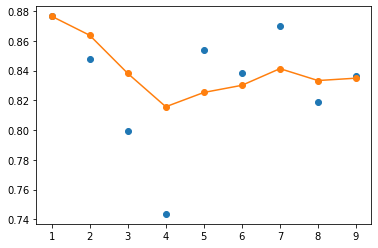

In [0]:
from matplotlib import pyplot
x_axis = [i for i in range(1, len(member)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

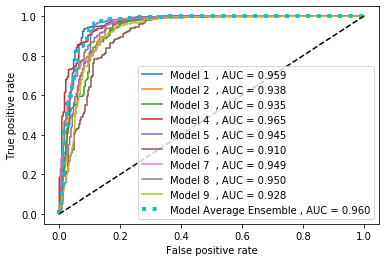

In [0]:
for i in range(len(member)):
  plt.plot(all_fpr[i],all_tpr[i],label='Model %d  , AUC = %0.3f' % (i+1,all_roc_auc[i]))
for i in range(1):
  fpr , tpr , _=  roc_curve(test_labels, ensemble_predictions_for_roc_model_average(member, test_data))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr,tpr,linestyle=':',linewidth=4,label='Model Average Ensemble , AUC = %0.3f' % roc_auc)
plt.legend(loc= 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()


# **Grid Search Weighted Average Ensemble**

In [0]:
from numpy import tensordot 
# make an ensemble prediction for multi-class classification
def ensemble_predictions_for_weight_average(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	
	summed = tensordot(yhats, weights, axes=((0),(0)))
	summed[summed > 0.5] = 1
	summed[summed <= 0.5] = 0
	result = summed.reshape(-1,)
	return result

In [0]:
def ensemble_predictions_for_roc_weight_average(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	
	summed = tensordot(yhats, weights, axes=((0),(0)))
	result = summed.reshape(-1,)
	return result

In [0]:
# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions_for_weight_average(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [0]:
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

In [0]:
# grid search weights
from itertools import product
def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.2, 0.4, 0.6]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))
	return list(best_weights)

In [0]:
n_model = 3
sub_member = [member[0],member[3],member[6]]
for i in range(n_model):
	_, test_acc = sub_member[i].evaluate(test_data, test_labels, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_model for _ in range(n_model)]
score = evaluate_ensemble(sub_member, weights, test_data, test_label)
print('Equal Weights Score: %.3f' % score)

# grid search weights
weights = grid_search(sub_member, test_data, test_labels)
score = evaluate_ensemble(sub_member, weights, test_data, test_label)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Model 1: 0.877
Model 2: 0.744
Model 3: 0.870
Equal Weights Score: 0.841
>[0.25 0.25 0.5 ] 0.856
>[0.2 0.2 0.6] 0.865
>[0.33333333 0.16666667 0.5       ] 0.867
Grid Search Weights: [0.3333333333333333, 0.16666666666666666, 0.4999999999999999], Score: 0.867


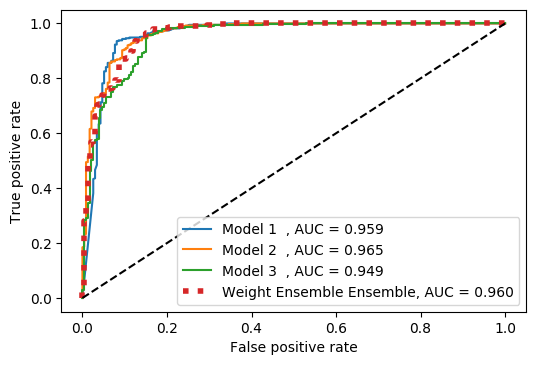

In [0]:
all_fpr_for_weight = []
all_tpr_for_weight = []
all_roc_auc_for_weight = []
n_model = 3

plt.figure(dpi=100)
for i in range(n_model):
  fpr , tpr , _=  roc_curve(test_labels, sub_member[i].predict(test_data, batch_size=16))
  roc_auc = auc(fpr,tpr)
  all_fpr_for_weight.append(fpr)
  all_tpr_for_weight.append(tpr)
  all_roc_auc_for_weight.append(roc_auc)
for i in range(n_model):
  plt.plot(all_fpr_for_weight[i],all_tpr_for_weight[i],label='Model %d  , AUC = %0.3f' % (i+1,all_roc_auc_for_weight[i]))
for i in range(1):
  fpr , tpr , _=  roc_curve(test_labels, ensemble_predictions_for_roc_weight_average(sub_member, weights, test_data))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr,tpr,linestyle=':',linewidth=4,label='Weight Ensemble Ensemble, AUC = %0.3f' % roc_auc)
plt.legend(loc= 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# **New Model With Average Models Weights**

In [0]:
from keras.models import clone_model
# create a model from the weights of multiple models
def model_weight_ensemble(members, weights):
	# determine how many layers need to be averaged
	n_layers = len(members[0].get_weights())
	# create an set of average model weights
	avg_model_weights = list()
	for layer in range(n_layers):
		# collect this layer from each model
		layer_weights = np.array([model.get_weights()[layer] for model in members])
		# weighted average of weights for this layer
		avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
		# store average layer weights
		avg_model_weights.append(avg_layer_weights)
	# create a new model with the same structure
	model = clone_model(members[0])
	# set the weights in the new
	model.set_weights(avg_model_weights)
	model_compile(model)
	return model

In [0]:
def ensemble_predictions_for_roc_average_model(model, testX):
	yhats = [model.predict(testX)]
	yhats = np.array(yhats)
	result = yhats.reshape(-1,)
	return result

In [0]:
weights = [1.0/len(member) for i in range(1, len(member)+1)]
average_model = model_weight_ensemble(member, weights)


## ROC for Average Model

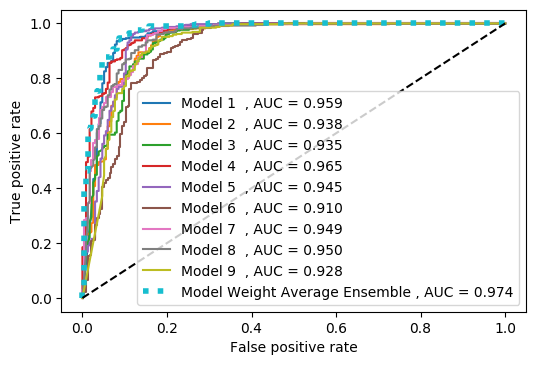

In [0]:
all_fpr = []
all_tpr = []
all_roc_auc = []
plt.figure(dpi=100)
for i in range(len(member)):
  fpr , tpr , _=  roc_curve(test_labels,member[i].predict(test_data, batch_size=16))
  roc_auc = auc(fpr,tpr)
  all_fpr.append(fpr)
  all_tpr.append(tpr)
  all_roc_auc.append(roc_auc)
  plt.plot(all_fpr[i],all_tpr[i],label='Model %d  , AUC = %0.3f' % (i+1,all_roc_auc[i]))
for i in range(1):
  fpr , tpr , _=  roc_curve(test_labels, ensemble_predictions_for_roc_average_model(average_model, test_data))
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr,tpr,linestyle=':',linewidth=4,label='Model Weight Average Ensemble , AUC = %0.3f' % roc_auc)
plt.legend(loc= 'lower right')
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [0]:
_,test_score = average_model.evaluate(test_data,test_labels)
print("Model {} Accuracy on test set: {}".format(i+1,test_score))

624/624 [==============================] - 1s 2ms/step
Model 1 Accuracy on test set: 0.9166666666666666
